**1. Using Time Domain Power Spectral Descriptors (TDPSD) Feature Set**  
**2. Using individual dataset**

In [1]:
!pip install libemg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 7.1 MB/s eta 0:00:00
  Created wheel for libemg: filename=libemg-0.0.1-py3-none-any.whl size=70338 sha256=f07a98c50dd7411dd3d46c22910a6327d373ee314cf691e26941446f1c96458a
  Stored in directory: /root/.cache/pip/wheels/52/29/b7/c395fce515bf8995f6c17ffa968697b66fd497a4c6a1c04481
Successfully built libemg


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipyio
import seaborn as sns
import pandas as pd
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
from google.colab import drive
import os

**Reading Dataset**

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
gestures_label = {
	 'Thumb_UP' : 0,
	 'Index' : 1,
	 'Right_Angle' : 2,
	 'Peace' : 3,
	 'Index_Little' : 4,
	 'Thumb_Little' : 5,
	 'Hand_Close' : 6,
	 'Hand_Open' : 7,
	 'Wrist_Extension' : 8,
	 'Wrist_Flexion' : 9,
	 'Ulner_Deviation' : 10,
	 'Radial_Deviation' : 11
}

gestures = ['Thumb_UP', 'Index_Little', 'Right_Angle', 'Peace', 'Index', 'Thumb_Little', 'Hand_Close', 'Hand_Open',
	 'Wrist_Extension', 'Wrist_Flexion', 'Ulner_Deviation', 'Radial_Deviation'
]

In [6]:
persons = ["Arifa", "Arnob", "Ashis", "Bayezid", "Bushra", "Choity_new", "Eftekhar",
           "Fahim", "Humaid", "Humayun", "Johir", "Joy", "Mamun", "Noman", "Piyus", "Sazzad",
           "Shafi", "Shourav", "Tamim", "Wadud"]

In [7]:
def get_gesture_label(gesture):
  return gestures_label [gesture];

In [118]:
def feature_extraction(channelvalues, gesture):
  # creating windows
  windows = get_windows(channelvalues, 150, 150)
  # extract feature
  fe = FeatureExtractor()
  feature_list = ['MAV', 'SSC', 'ZC', 'WL', 'AR4']
  features = fe.extract_feature_group('TDPSD', windows)
  print(features.keys())
  #print("Len : "+str(len(features)))
  # creating feature matrixs
  extracted_feature_array = []
  extracted_gesture_array = []
  for i in range(33):
    features_matrix = [
        features['M0'][i],
        features['M2'][i],
        features['M4'][i],
        features['SPARSI'][i],
        features['IRF'][i],
        features['WLF'][i],
    ]
    #print(features['MAV'].shape)
    #print(features['AR'].shape)
    #features_matrix = (features_matrix-np.min(features_matrix))/(np.max(features_matrix)-np.min(features_matrix))
    extracted_feature_array.append(features_matrix)
    extracted_gesture_array.append(get_gesture_label(gesture))
  return extracted_feature_array, extracted_gesture_array

In [119]:
def get_processed_data(matfilepath, gesture):
  # read mat file
  matdata = scipyio.loadmat(matfilepath)
  # transpose the matrix
  values = np.transpose(matdata['value'])
  # remove the first 3000 values
  values = values[3000:]
  return feature_extraction(values, gesture)


In [120]:
def get_input(persons, gestures, orientaion="Rest"):
  input_array = []
  input_gest = []
  for person in persons:
    for gest in gestures:
      for i in range(5):
        matfilepath = "gdrive/My Drive/Forearm Invariant Data/"+person+"/"+orientaion+"/"+gest+"-"+str(i+1)+".mat"
        #print(matfilepath)
        processed_matrix, gesture_array = get_processed_data(matfilepath, gest)
        gest_label = get_gesture_label(gest)
        input_array = input_array + processed_matrix
        input_gest = input_gest + gesture_array
  return input_array, input_gest

In [121]:
X, Y = get_input(['Arifa'], gestures)

dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4',

In [103]:
len(X), len(Y)

(1980, 1980)

In [122]:
#
df = pd.DataFrame(X[0])
index = pd.Index(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
df = df.set_index(index)
df

,0,1,2,3,4,5,6,7
M0,-0.951322,-0.944977,-0.963565,-0.950679,-0.965322,-0.954302,-0.963085,-0.955371
M2,-0.723165,-0.719018,-0.877726,-0.732681,-0.748613,-0.671608,-0.753926,0.148463
M4,-0.803070,-0.791177,-0.906614,-0.788778,-0.787047,-0.758373,-0.793396,-0.921300
SPARSI,-0.998982,-0.997180,-0.994085,-0.998929,-0.999980,-0.999965,-0.999772,-0.826898
IRF,-0.990167,-0.982667,-0.983914,-0.983501,-0.986788,-0.993907,-0.982048,-0.354377
WLF,-0.959283,-0.931924,-0.954225,-0.883033,-0.834486,-0.901721,-0.877145,-0.992754


In [123]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((1980, 6, 8), (1980,))

**Model Building**

In [124]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,Y,
    test_size = .2, shuffle=True, random_state=0
)

In [125]:
len(x_train), len(y_train)

(1584, 1584)

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the input shape
input_shape = (6, 8)

# Create a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a MaxPooling1D layer (optional)
model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it to a Dense layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))

# Add a Dense layer
model.add(Dense(32, activation='relu'))

# Add a Dense layer
model.add(Dense(16, activation='relu'))

# Output layer for classification (adjust units according to the number of classes)
# Assuming classes are integers starting from 0
model.add(Dense(12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 4, 32)             800       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 2, 32)             0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                      

In [127]:
# Fit the model with training data
history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/70
50/50 [==============================] - 1s 7ms/step - loss: 2.4829 - accuracy: 0.0966 - val_loss: 2.4704 - val_accuracy: 0.1667
Epoch 2/70
50/50 [==============================] - 0s 3ms/step - loss: 2.4584 - accuracy: 0.1174 - val_loss: 2.4330 - val_accuracy: 0.1843
Epoch 3/70
50/50 [==============================] - 0s 3ms/step - loss: 2.3945 - accuracy: 0.1749 - val_loss: 2.3284 - val_accuracy: 0.1944
Epoch 4/70
50/50 [==============================] - 0s 3ms/step - loss: 2.2649 - accuracy: 0.1900 - val_loss: 2.1633 - val_accuracy: 0.2096
Epoch 5/70
50/50 [==============================] - 0s 3ms/step - loss: 2.1147 - accuracy: 0.1995 - val_loss: 2.0476 - val_accuracy: 0.2576
Epoch 6/70
50/50 [==============================] - 0s 3ms/step - loss: 2.0065 - accuracy: 0.2614 - val_loss: 1.9779 - val_accuracy: 0.2803
Epoch 7/70
50/50 [==============================] - 0s 3ms/step - loss: 1.8873 - accuracy: 0.3068 - val_loss: 1.8190 - val_accuracy: 0.3333
Epoch 8/70
50/50 [==

**Classification Report**

In [128]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report : ")
print(classification_report(y_test, y_pred_classes))

13/13 [==============================] - 0s 3ms/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.74      0.60      0.66        42
           1       0.56      0.69      0.62        29
           2       0.85      0.91      0.88        32
           3       0.48      0.50      0.49        30
           4       0.54      0.59      0.57        32
           5       0.62      0.62      0.62        29
           6       0.55      0.41      0.47        29
           7       0.58      0.79      0.67        33
           8       0.87      0.94      0.91        36
           9       0.56      0.77      0.65        31
          10       0.36      0.14      0.20        36
          11       0.97      0.89      0.93        37

    accuracy                           0.66       396
   macro avg       0.64      0.65      0.64       396
weighted avg       0.65      0.66      0.64       396



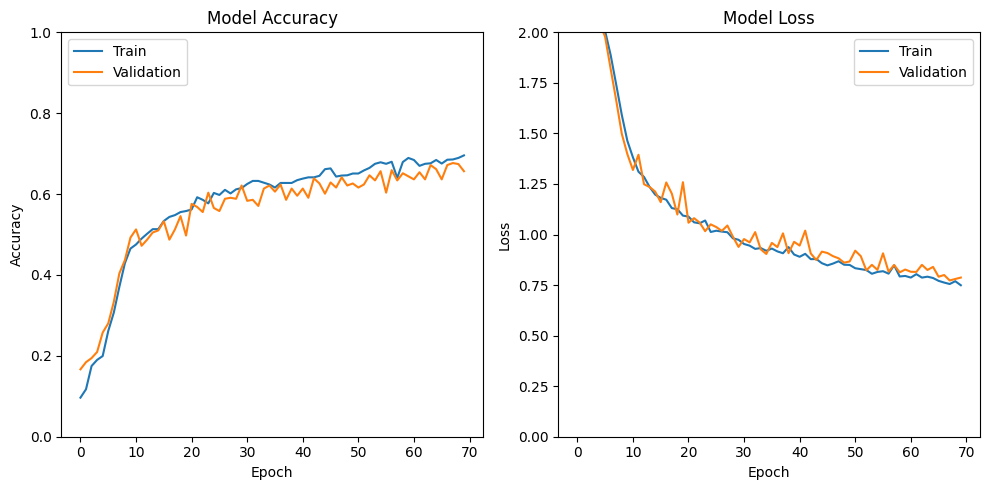

In [129]:
# Plotting model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.ylim(0, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.ylim(0, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)

**Validation with Pronation Data**

In [130]:
x_pronation, y_pronation = get_input(['Arifa'], gestures, "Pronation")
x_pronation = np.array(x_pronation)
y_pronation = np.array(y_pronation)

dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4',

In [131]:
pronation_results = model.evaluate(x_pronation, y_pronation, batch_size=32)
print(pronation_results)

62/62 [==============================] - 0s 2ms/step - loss: 2.5548 - accuracy: 0.3753
[2.5548455715179443, 0.37525251507759094]


**Validation with Supination Data**

In [132]:
x_supination, y_supination = get_input(['Arifa'], gestures, "Supination")
x_supination = np.array(x_supination)
y_supination = np.array(y_supination)

dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4', 'SPARSI', 'IRF', 'WLF'])
dict_keys(['M0', 'M2', 'M4',

In [133]:
supination_results = model.evaluate(x_supination, y_supination, batch_size=32)
print(supination_results)

62/62 [==============================] - 0s 2ms/step - loss: 2.0900 - accuracy: 0.3944
[2.089968681335449, 0.39444443583488464]
